In [809]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split
import random
from tqdm import tqdm

In [810]:
def oneHot(position, maxLength):
  res = np.zeros(maxLength)
  res[position] = 1
  return res

In [811]:
gloveOutput = {'0': oneHot(0,13), '1': oneHot(1,13), '2': oneHot(2,13), '3': oneHot(3,13), '4': oneHot(4,13),
                '5': oneHot(5,13), '6': oneHot(6,13), '7': oneHot(7,13), '8': oneHot(8,13), '9': oneHot(9,13),
                '-': oneHot(10,13), '<sot>': oneHot(11,13), '<eot>': oneHot(12,13)}
reverseGloveOutput = {0 : '0', 1 : '1', 2 : '2', 3 : '3', 4 : '4', 5 : '5', 6 : '6', 7 : '7', 8 : '8', 9 : '9', 10 : '-', 11 : '<sot>', 12 : '<eot>'}

In [812]:
gloveInput = {' ': oneHot(0,33), '/': oneHot(1,33), '0': oneHot(2,33), '1': oneHot(3,33), '2': oneHot(4,33), '3': oneHot(5,33),
        '4': oneHot(6,33), '5': oneHot(7,33), '6': oneHot(8,33), '7': oneHot(9,33), '8': oneHot(10,33), '9': oneHot(11,33),
        'a': oneHot(12,33), 'b': oneHot(13,33), 'c': oneHot(14,33), 'd': oneHot(15,33), 'e': oneHot(16,33), 'f': oneHot(17,33),
        'g': oneHot(18,33), 'h': oneHot(19,33), 'i': oneHot(20,33), 'j': oneHot(21,33), 'l': oneHot(22,33), 'm': oneHot(23,33), 
        'n': oneHot(24,33), 'o': oneHot(25,33), 'p': oneHot(26,33), 'r': oneHot(27,33), 's': oneHot(28,33), 't': oneHot(29,33),
        'u': oneHot(30,33), 'v': oneHot(31,33), 'y': oneHot(32,33)}

reverseGloveInput = {0 : ' ', 1 : '/', 2 : '0', 3 : '1', 4 : '2', 5 : '3',  6 : '4', 7 : '5', 8 : '6',  9 : '7',  10 : '8',  11 : '9', 12 : 'a', 13 : 'b', 14 : 'c', 15 : 'd',
        16 : 'e', 17 : 'f', 18 : 'g', 19 : 'h', 20 : 'i', 21 : 'j', 22 : 'l', 23 : 'm' , 24 : 'n' , 25 : 'o', 26 : 'p', 27 : 'r', 28 : 's', 29 : 't', 30 : 'u', 31 : 'v',
        32 : 'y'} 

In [813]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [814]:
days = ['mon','monday','tue','tuesday','wed','wednesday','thu','thursday','fri','friday','sat','saturday','sun','sunday']

In [815]:
def preProcess(inputWithOutPreProcess):
  wordlist = inputWithOutPreProcess.split()
  for j in wordlist:
    if j in days:
      inputWithOutPreProcess = inputWithOutPreProcess.replace(j, "\b")
  return inputWithOutPreProcess

In [816]:
path = open('/home/saurav/DLNP Assignment/DLNLP_ASS4/Assignment4aDataset.txt','r')
data = path.readlines()

for i in range(0, len(data)):
  data[i] = data[i].strip()
  data[i] = data[i].lower()
  data[i] = data[i].split(", ")

In [817]:
df = pd.DataFrame(data = data, columns = ['input', 'output'])
df.head(10)

,input,output
0,'may 20 2034','2034-05-20'
1,'9 may 1630','1630-05-09'
2,'15/03/2014','2014-03-15'
3,'mar 16 1675','1675-03-16'
4,'jun 16 1640','1640-06-16'
5,'friday 1791 2 09','1791-09-02'
6,'wed 1776 11 september','1776-09-11'
7,'1833 9 jun','1833-06-09'
8,'sun 26 oct 1788','1788-10-26'
9,'1685 30 oct','1685-10-30'


In [818]:
inputX = np.char.lower(np.char.replace(list(df['input']),"'",""))
inputY = np.char.lower(np.char.replace(list(df['output']),"'",""))

In [819]:
def preProcess1(sample):
  tokens = sample.split()
  filteredTokens = []
  for i in tokens:
    if i not in days:
      filteredTokens.append(i)
  charList = []
  n = len(filteredTokens)
  for i in range(n):
    currCharList = list(filteredTokens[i])
    if(i != n-1):
      currCharList.append(' ')
    charList.extend(currCharList)
  return charList


def preProcess2(charList, maxLength):
  for i in range(maxLength - len(charList)):
    charList.append(' ')
  vectorRep = []
  for i in charList:
    vectorRep.append(gloveInput[i]);
  return vectorRep


In [820]:
completeCharList = [preProcess1(sample) for sample in inputX]
maxLength = 0
for charList in completeCharList:
  maxLength = max(maxLength, len(charList))

train_X = [preProcess2(charList, maxLength) for charList in completeCharList]
train_X = np.array(train_X)



train_Y = []
for sample in inputY:
  temp = list(sample)
  temp.insert(0, '<sot>')
  temp.append('<eot>')
  train_Y.append(temp)
train_Y = np.array(train_Y)



In [821]:
y = []
for i in train_Y:
  ss = []
  for j in i:
    ss.append(gloveOutput[j])
  y.append(ss)
train_Y = np.array(y)


In [822]:
print(train_X.shape)
print(train_Y.shape)

(40000, 17, 33)
(40000, 12, 13)


In [823]:
train_x = torch.Tensor(train_X)
train_y = torch.Tensor(train_Y)
train_y = train_y.type(torch.LongTensor)
dataset = TensorDataset(train_x,train_y)
training, validation = random_split(dataset, [36000, 4000])
batch_size = 400
trainLoader = torch.utils.data.DataLoader(dataset=training, batch_size=batch_size, shuffle=True)
valLoader = torch.utils.data.DataLoader(dataset=validation, batch_size=batch_size, shuffle=True)

In [824]:
class Encoder(nn.Module):
    def __init__(self, inputSize, outputSize, num_layers, dropout):
        super(Encoder, self).__init__()
        self.inputSize = inputSize
        self.outputSize = outputSize
        self.num_layers = num_layers
        self.dropout = dropout
        self.LSTM = nn.LSTM(inputSize, outputSize, num_layers = num_layers, batch_first = True, bidirectional = False, dropout = dropout)

    def forward(self, x):
        output, (hidden, cell) = self.LSTM(x)
        return output, hidden, cell

In [825]:
class Decoder(nn.Module):
    def __init__(self, inputSize, hiddenSize, outputSize, num_layers, dropout):
        super(Decoder, self).__init__()
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize
        self.outputSize = outputSize
        self.num_layers = num_layers
        self.dropout = dropout
        self.LSTM = nn.LSTM(inputSize, hiddenSize, num_layers = num_layers, dropout = dropout, batch_first = True, bidirectional = False)
        self.FC = nn.Linear(hiddenSize, inputSize)

    def forward(self, x, hidden, cell):
        output, (hidden, cell) = self.LSTM(x.float(), (hidden, cell))
        output = self.FC(output)
        return output, hidden, cell

In [826]:
class AttentionDecoder(nn.Module):
    def __init__(self, inputSize, hiddenSize, outputSize, num_layers, dropout):
        super(AttentionDecoder, self).__init__()
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize
        self.outputSize = outputSize
        self.num_layers = num_layers
        self.dropout = dropout

        self.linear1 = nn.Linear(inputSize, hiddenSize)
        self.attentionLinear1 = nn.Linear(self.hiddenSize * 2, 17)
        self.attentionLinear2 = nn.Linear(self.hiddenSize*2, self.inputSize)

        self.lstm = nn.LSTM(inputSize, hiddenSize, num_layers, batch_first = True, dropout = dropout, bidirectional = False)   
        
        self.linear2 = nn.Linear(hiddenSize, outputSize)
            
    def forward(self, input, hidden, cell, encoderOutputs):  
        
        out = self.linear1(input)
        attentionWeights = F.softmax(self.attentionLinear1(torch.cat((out, (hidden.squeeze(0)).unsqueeze(1)), 2)), dim=2)
        weights = torch.bmm(attentionWeights, encoderOutputs)
        output = torch.cat((out, weights), 2)
        output = self.attentionLinear2(output)
        output = F.relu(output)
        output, (hidden, cell) = self.lstm(output, (hidden, cell))
        output = self.linear2(output)
        # return output, hidden, cell
        return output, hidden, cell, attentionWeights



In [827]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, input, target = None, teacherForceRatio = 0.5):
        batchSize = input.shape[0]
        targetLength = train_y.shape[1]
        targetVocabSize = train_y.shape[2]
        outputTensor = torch.zeros(batchSize, targetLength, targetVocabSize).to(device)
        attentionweightTensor = torch.zeros(batchSize, targetLength, 17).to(device)
        encoderOutput, hidden, cell = self.encoder(input)
        # print(hidden.shape)
        if(target == None):
            x = torch.Tensor(gloveOutput['<sot>']).unsqueeze(0).unsqueeze(0).to(device)
        else:
            x = target[:, 0, :].unsqueeze(1)
        for t in range(1, targetLength):
            # output, hidden, cell = self.decoder(x.float(), hidden, cell)
            output, hidden, cell, attentionWeight = self.decoder(x.float(), hidden, cell, encoderOutput)
            # print(attentionWeight)
            outputTensor[:, t-1, :] = output.squeeze(dim = 1)
            attentionweightTensor[:, t-1, :] = attentionWeight.squeeze(dim = 1)
            x = target[:, t, :].unsqueeze(1) if random.random() < teacherForceRatio else output

        # return outputTensor
        return outputTensor, attentionweightTensor


In [828]:
epochs, lr = 30, 0.003
encoderNetwork = Encoder(inputSize = 33, outputSize = 200, num_layers = 1, dropout = 0).to(device)
decoderNetwork = AttentionDecoder(inputSize = 13, hiddenSize = 200, outputSize = 13, num_layers = 1, dropout = 0).to(device)
model = Seq2Seq(encoder = encoderNetwork, decoder = decoderNetwork).to(device)
criterion = nn.MSELoss()
optimiser = optim.Adam(model.parameters(), lr = lr)

In [829]:
trainLoss = []
valLoss = []
for epoch in range(epochs):
    tLoss = 0
    vLoss = 0
    count = 0
    model.train()
    for x, y in tqdm(trainLoader):
        x, y = x.to(device), y.to(device) 
        # output = model(x, y)
        output, weight = model(x, y)
        optimiser.zero_grad()
        loss = criterion(output[:, 1:-1, :], y[:, 1:-1, :].float())
        loss.backward()
        optimiser.step()
        tLoss += loss.item()
        
    
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(valLoader):
            x, y = x.to(device), y.to(device) 
            # output = model(x, y, 0)
            output, weight = model(x, y, 0)
            loss = criterion(output[:, 1:-1, :], y[:, 1:-1, :].float())
            vLoss += loss.item()

            predictedY = torch.argmax(output, dim = 2)
            trueY = torch.argmax(y, dim = 2)
            for batch in range(y.shape[0]):
                predictedIndexList = list(predictedY[batch].cpu().detach().numpy())
                predictedDate = ''.join(reverseGlove[i] for i in predictedIndexList[1: -1])
                trueIndexList = list(trueY[batch].cpu().detach().numpy())
                trueDate = ''.join(reverseGlove[i] for i in trueIndexList[1: -1])
                if(predictedDate == trueDate):
                    count += 1
    
    acc = (count/4000)*100
    print(f'Epoch {epoch+1} Training Loss: {tLoss/len(trainLoader)} Validation Loss: {vLoss/len(valLoader)} accuracy: {acc}')

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 44.46it/s]


Epoch 1 Training Loss: 0.05252940642337004 Validation Loss: 0.05411229319870472 accuracy: 0.0


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 43.45it/s]


Epoch 2 Training Loss: 0.03197866510599852 Validation Loss: 0.03900008499622345 accuracy: 0.0


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 42.73it/s]


Epoch 3 Training Loss: 0.024725930775619215 Validation Loss: 0.03671524487435818 accuracy: 0.05


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 43.11it/s]


Epoch 4 Training Loss: 0.019410224760779075 Validation Loss: 0.03152660895138979 accuracy: 0.27499999999999997


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 43.02it/s]


Epoch 5 Training Loss: 0.015586569910455081 Validation Loss: 0.024837260879576207 accuracy: 3.175


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 42.82it/s]


Epoch 6 Training Loss: 0.01206952908800708 Validation Loss: 0.017404238879680633 accuracy: 17.95


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 43.29it/s]


Epoch 7 Training Loss: 0.007862167440665264 Validation Loss: 0.00961513314396143 accuracy: 54.775


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 43.23it/s]


Epoch 8 Training Loss: 0.0049532951761244075 Validation Loss: 0.006168743409216404 accuracy: 70.1


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 41.94it/s]


Epoch 9 Training Loss: 0.0030410937848500907 Validation Loss: 0.003900349885225296 accuracy: 82.27499999999999


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 43.18it/s]


Epoch 10 Training Loss: 0.0019570768784938587 Validation Loss: 0.0024364445824176075 accuracy: 89.60000000000001


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 43.18it/s]


Epoch 11 Training Loss: 0.001215667543389524 Validation Loss: 0.0013212976919021457 accuracy: 95.275


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 42.75it/s]


Epoch 12 Training Loss: 0.0008259967564501696 Validation Loss: 0.0009980594681110234 accuracy: 96.775


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 43.28it/s]


Epoch 13 Training Loss: 0.0006164926018552958 Validation Loss: 0.000693727092584595 accuracy: 96.95


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 42.68it/s]


Epoch 14 Training Loss: 0.00046193175561105214 Validation Loss: 0.0005660205730237067 accuracy: 97.0


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 42.81it/s]


Epoch 15 Training Loss: 0.0003825703299500876 Validation Loss: 0.0005815974640427157 accuracy: 96.875


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 43.60it/s]


Epoch 16 Training Loss: 0.0003580786950705159 Validation Loss: 0.0004729201376903802 accuracy: 97.175


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 43.57it/s]


Epoch 17 Training Loss: 0.0003073939700294027 Validation Loss: 0.00044374408316798507 accuracy: 96.925


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 42.70it/s]


Epoch 18 Training Loss: 0.0002812820622542252 Validation Loss: 0.0004155768285272643 accuracy: 97.05


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 30.32it/s]


Epoch 19 Training Loss: 0.0002598010933272437 Validation Loss: 0.0004107927205041051 accuracy: 97.125


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 31.06it/s]


Epoch 20 Training Loss: 0.00026600978962960654 Validation Loss: 0.000394236232386902 accuracy: 97.0


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 30.07it/s]


Epoch 21 Training Loss: 0.0002371323473198572 Validation Loss: 0.00039673236606176945 accuracy: 97.15


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 41.70it/s]


Epoch 22 Training Loss: 0.00022233656980258983 Validation Loss: 0.0004038830637000501 accuracy: 97.02499999999999


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 43.41it/s]


Epoch 23 Training Loss: 0.0002215731290359852 Validation Loss: 0.0003762264808756299 accuracy: 97.175


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 43.70it/s]


Epoch 24 Training Loss: 0.00020581343305821066 Validation Loss: 0.0006809134007198736 accuracy: 95.575


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 41.93it/s]


Epoch 25 Training Loss: 0.0009244546707325046 Validation Loss: 0.0004341923107858747 accuracy: 96.975


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 43.50it/s]


Epoch 26 Training Loss: 0.00021811998522025533 Validation Loss: 0.0003873540612403303 accuracy: 96.95


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 42.70it/s]


Epoch 27 Training Loss: 0.00020652352500797455 Validation Loss: 0.0003705923445522785 accuracy: 97.2


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 43.41it/s]


Epoch 28 Training Loss: 0.0001976221601378509 Validation Loss: 0.0003859502365230583 accuracy: 97.1


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 43.35it/s]


Epoch 29 Training Loss: 0.00019160919940380456 Validation Loss: 0.00038080657832324506 accuracy: 97.02499999999999


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 44.12it/s]

Epoch 30 Training Loss: 0.00019680718370283204 Validation Loss: 0.0003524571380694397 accuracy: 97.125


In [830]:
for x, y in valLoader:
    x, y = x.to(device), y.to(device) 
    # output = model(x, y, 0)
    output, weight = model(x, y, 0)
    # print(weight)
    inputX = torch.argmax(x, dim = 2)
    predictedY = torch.argmax(output, dim = 2)
    trueY = torch.argmax(y, dim = 2)
    for batch in range(10):
        predictedIndexList = list(predictedY[batch].cpu().detach().numpy())
        predictedDate = ''.join(reverseGlove[i] for i in predictedIndexList[1: -1])
        trueIndexList = list(trueY[batch].cpu().detach().numpy())
        trueDate = ''.join(reverseGlove[i] for i in trueIndexList[1: -1])
        inputIndexList = list(inputX[batch].cpu().detach().numpy())
        inputDate = ''.join(reverseGloveInput[i] for i in inputIndexList)
        print(inputDate,', ', trueDate, '---->', predictedDate)
    break

jan 24 1752       ,  1752-01-24 ----> 1752-01-24
1981 15 december  ,  1981-12-15 ----> 1981-12-15
23 february 1806  ,  1806-02-23 ----> 1806-02-23
december 18 1874  ,  1874-12-18 ----> 1874-12-18
nov 3 2070        ,  2070-11-03 ----> 2070-11-03
4/22/27           ,  1827-04-22 ----> 1727-04-22
1906 14 july      ,  1906-07-14 ----> 1906-07-14
april 3 2000      ,  2000-04-03 ----> 2000-04-03
july 7 1559       ,  1559-07-07 ----> 1559-07-07
5 march 2016      ,  2016-03-05 ----> 2016-03-05


8 sept 1918       ----> 1918-09-08


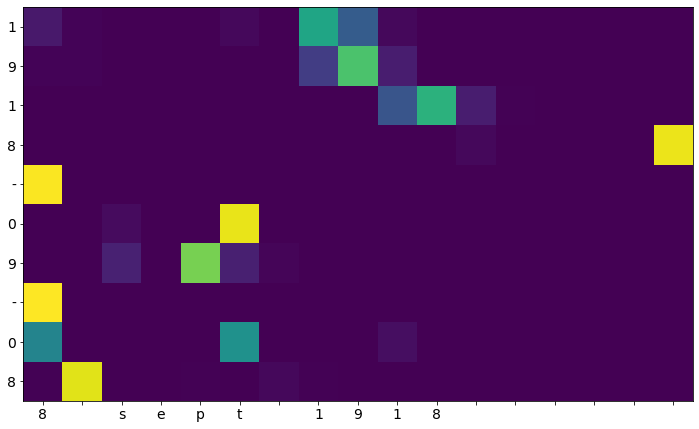

In [835]:
def visualize(str):
    complete_char_list = human_date_to_char_list(str)
    train_X = [char_list_to_vector(complete_char_list,17)]
    train_X = torch.Tensor(np.array(train_X))
    train_X = train_X.to(device)
    output, weight = model(train_X, teacherForceRatio = 0)
    predictedY = torch.argmax(output, dim = 2)
    inputX = torch.argmax(train_X, dim = 2)
    batch = 0
    predictedIndexList = list(predictedY[batch].cpu().detach().numpy())
    predictedDate = ''.join(reverseGloveOutput[i] for i in predictedIndexList[1: -1])
    inputIndexList = list(inputX[batch].cpu().detach().numpy())
    inputDate = ''.join(reverseGloveInput[i] for i in inputIndexList)
    print(inputDate,'---->', predictedDate)
    
    plt.imshow(weight[:,1:-1,:].squeeze().detach().cpu().numpy())
    x_pos = np.arange(len(inputDate))
    y_pos = np.arange(len(predictedDate))
    plt.rcParams["figure.figsize"] = (12,12)
    plt.xticks(x_pos, list(inputDate), color='black', fontsize='14')
    plt.yticks(y_pos, list(predictedDate), color='black', fontsize='14', horizontalalignment='right')
    plt.show()
        
visualize('8 sept 1918')
